In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow_hub as hub
import time
import pandas as pd


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
data_dir = 'C:\\Users\\ardo\\Documents\\semai\\dataset\\ripeness\\ripeness_v7.2'
print(data_dir)

C:\Users\ardo\Documents\semai\dataset\ripeness\ripeness_v7.2


In [3]:
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 593 files belonging to 4 classes.
Using 475 files for training.


In [4]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 593 files belonging to 4 classes.
Using 118 files for validation.


In [5]:
class_names = train_ds.class_names
print(class_names)

['belum matang', 'jankos', 'lewat matang', 'matang']


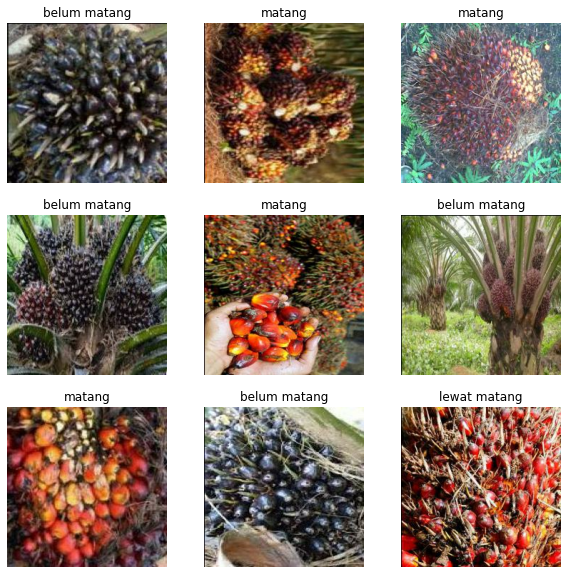

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [8]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [9]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

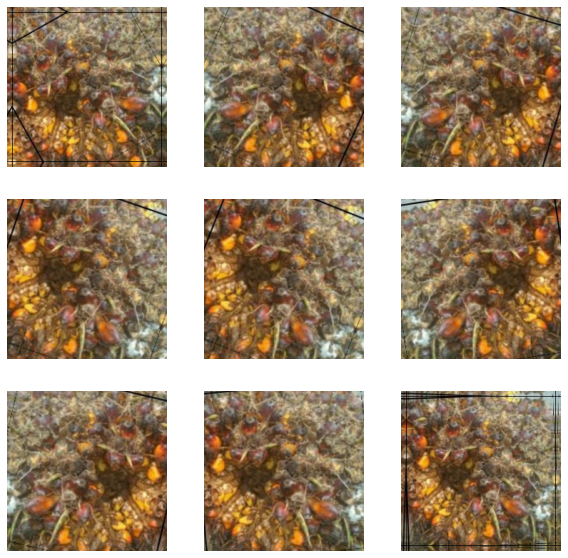

In [10]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [11]:
num_classes = 4

model = Sequential([
  data_augmentation,
  normalization_layer,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)       

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 6
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/6
15/15 [==============================] - 2s 101ms/step - loss: 1.4438 - accuracy: 0.4084 - val_loss: 1.0356 - val_accuracy: 0.4831
Epoch 2/6
15/15 [==============================] - 1s 64ms/step - loss: 0.9690 - accuracy: 0.6484 - val_loss: 0.7684 - val_accuracy: 0.6610
Epoch 3/6
15/15 [==============================] - 1s 63ms/step - loss: 0.7956 - accuracy: 0.7011 - val_loss: 0.6446 - val_accuracy: 0.7288
Epoch 4/6
15/15 [==============================] - 1s 65ms/step - loss: 0.6747 - accuracy: 0.7074 - val_loss: 0.5528 - val_accuracy: 0.7712
Epoch 5/6
15/15 [==============================] - 1s 63ms/step - loss: 0.6045 - accuracy: 0.7305 - val_loss: 0.5470 - val_accuracy: 0.7797
Epoch 6/6
15/15 [==============================] - 1s 66ms/step - loss: 0.6504 - accuracy: 0.7158 - val_loss: 0.5943 - val_accuracy: 0.7373


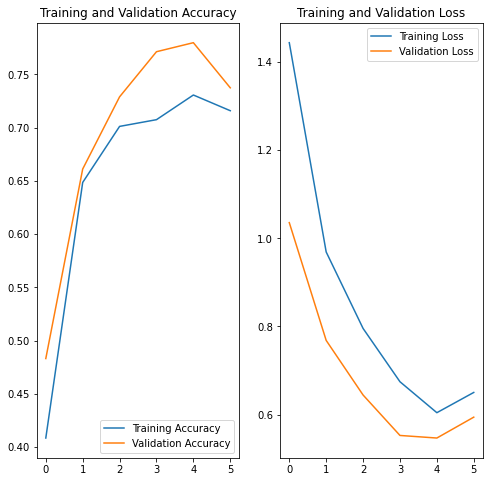

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

[[-1.3959025 -2.192593   2.1814656  3.215992 ]]
['belum matang', 'jankos', 'lewat matang', 'matang']
[0.007 0.003 0.259 0.73 ]
This image most likely belongs to matang with a 73.0 percent confidence.


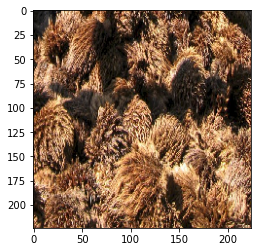

In [14]:
tandan_url = "https://akacn.ac.id/wp-content/uploads/2020/11/tandon-kosong-1.png"
tandan_loc = "C:\\Users\\ardo\\Documents\\personal\\dev\\notebook\\test_ripe_0604\\tandan_kos.jpg"
tandan_path = tf.keras.utils.get_file(tandan_loc, origin=tandan_url)

img = keras.preprocessing.image.load_img(
    tandan_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(predictions)
print(class_names)
print(np.round(score, 3))

print(
    "This image most likely belongs to {} with a {:.1f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

plt.imshow(img)

In [24]:
#model = keras.models.load_model(saved_model_path, custom_objects={'KerasLayer':hub.KerasLayer})
model_loc = 'C:\\Users\\ardo\\Documents\\semai\\peltarion\\experiment_40_copy_2.h5'
#model = keras.models.load_model(model_loc, custom_objects={'KerasLayer':hub.KerasLayer})
model = keras.models.load_model(model_loc, compile=False, custom_objects={'KerasLayer':hub.KerasLayer})
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ud62a5401-f467-4100-81dd-299c2a [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
u7072fa90-4696-4296-b996-8f1f72 (None, 224, 224, 3)  12          ud62a5401-f467-4100-81dd-299c2a74
__________________________________________________________________________________________________
u98b6eed3-7bde-4371-be29-75bf00 (None, 225, 225, 3)  0           u7072fa90-4696-4296-b996-8f1f725a
__________________________________________________________________________________________________
u164d10c6-7c7d-45d0-8869-2be0f4 (None, 112, 112, 48) 1296        u98b6eed3-7bde-4371-be29-75bf001d
_______________________________________________________________________________________

[[46.02339   0.       12.625004 69.06915 ]]
['belum matang', 'jankos', 'lewat matang', 'matang']
[0. 0. 0. 1.]
This image most likely belongs to matang with a 100.0 percent confidence.


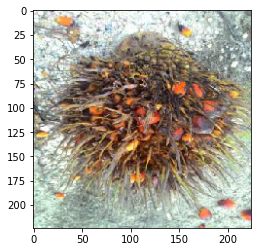

In [25]:
tandan_url = "https://docplayer.info/docs-images/70/62137124/images/31-0.jpg"
tandan_loc = "C:\\Users\\ardo\\Documents\\personal\\dev\\notebook\\test_ripe_0604\\tandan_lewat.jpg"
tandan_path = tf.keras.utils.get_file(tandan_loc, origin=tandan_url)

test_img = "C:\\Users\\ardo\\Documents\\semai\\dataset\\ripeness\\ripeness_v7.1\\belum matang\\4_jpg.rf.6da018ee5194f730fa76294e2ea00131.jpg"

img = keras.preprocessing.image.load_img(
    tandan_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(predictions)
print(class_names)
print(np.round(score, 3))

print(
    "This image most likely belongs to {} with a {:.1f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

plt.imshow(img)

In [26]:
# Get images and labels batch from validation dataset generator
val_image_batch, val_label_batch = next(iter(val_ds))
true_label_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)

# Get predictions for images batch
tf_model_predictions = model.predict(val_image_batch)
score = tf.nn.softmax(tf_model_predictions)
print("Prediction results shape:", score.shape)
score = np.round(score, 4)
# >> Prediction results shape: (32, 5)

# Convert prediction results to Pandas dataframe, for better visualization
tf_pred_dataframe = pd.DataFrame(score)
tf_pred_dataframe.columns = class_names

tf_pred_dataframe.head()


Validation batch shape: (32, 224, 224, 3)
Prediction results shape: (32, 4)


,belum matang,jankos,lewat matang,matang
0,0.0000,0.0,0.0,1.0000
1,0.0000,0.0,0.0,1.0000
2,1.0000,0.0,0.0,0.0000
3,0.0985,0.0,0.0,0.9015
4,1.0000,0.0,0.0,0.0000


In [27]:
tf_pred_dataframe_ori = pd.DataFrame(tf_model_predictions)
tf_pred_dataframe_ori.columns = class_names

tf_pred_dataframe_ori.head()

,belum matang,jankos,lewat matang,matang
0,21.612877,0.0,5.424595,75.147438
1,0.000000,0.0,14.992806,84.582031
2,69.720634,0.0,10.261219,54.104038
3,88.114296,0.0,0.000000,90.328720
4,70.296791,0.0,5.962309,53.350357


['matang' 'matang' 'belum matang' 'matang' 'belum matang' 'matang'
 'belum matang' 'belum matang' 'matang' 'matang' 'belum matang'
 'belum matang' 'matang' 'belum matang' 'belum matang' 'belum matang'
 'matang' 'matang' 'belum matang' 'belum matang' 'matang' 'belum matang'
 'belum matang' 'belum matang' 'matang' 'belum matang' 'matang' 'matang'
 'matang' 'belum matang' 'matang' 'belum matang']
Labels:            [0 0 3 3 2 1 3 2 3 0 3 2 0 0 3 0 0 3 3 0 3 3 3 3 3 3 0 3 3 0 1 3]
Predicted labels:  [3 3 0 3 0 3 0 0 3 3 0 0 3 0 0 0 3 3 0 0 3 0 0 0 3 0 3 3 3 0 3 0]


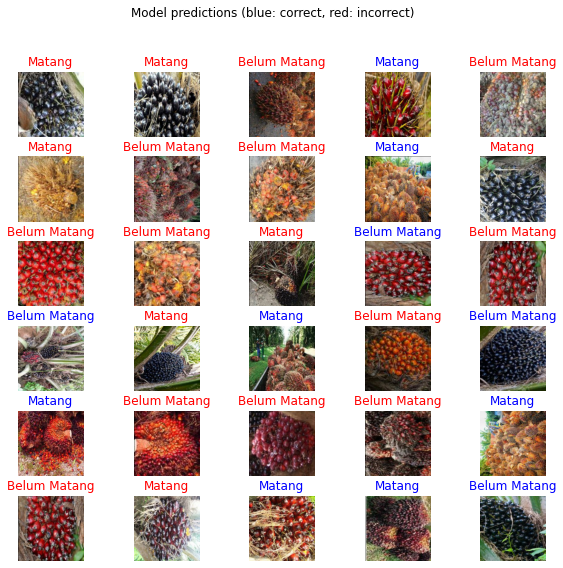

In [28]:
image_batch = val_image_batch.numpy()
label_batch = val_label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)

predicted_class_names = np.array(class_names)[predicted_ids]

print(predicted_class_names)
print("Labels:           ", label_batch)
print("Predicted labels: ", predicted_ids)

plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n].astype('uint8'))
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

In [27]:
timename = time.strftime("%Y%m%d%H%M%S")
tflite_path = "ripeness-" + timename + ".tflite"
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open(tflite_path, 'wb') as f:
  f.write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: C:\Users\ardo\AppData\Local\Temp\tmpgqw3r75y\assets


INFO:tensorflow:Assets written to: C:\Users\ardo\AppData\Local\Temp\tmpgqw3r75y\assets


In [28]:
timename = time.strftime("%Y%m%d%H%M%S")
tflite_q_path = "ripeness-q-" + timename + ".tflite"
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_q_model = converter.convert()
with open(tflite_q_path, 'wb') as f:
  f.write(tflite_q_model)

INFO:tensorflow:Assets written to: C:\Users\ardo\AppData\Local\Temp\tmpm1417czx\assets


INFO:tensorflow:Assets written to: C:\Users\ardo\AppData\Local\Temp\tmpm1417czx\assets


In [29]:
tflite_interpreter = tf.lite.Interpreter(model_path=tflite_path)
#tflite_interpreter = tf.lite.Interpreter(model_path='ripeness-20210406165419.tflite')

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])
print("\n== Output details ==")
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

print("\n\nAfter Conversion:\n\n")

tflite_interpreter.resize_tensor_input(input_details[0]['index'], (32, 224, 224, 3))
tflite_interpreter.resize_tensor_input(output_details[0]['index'], (32, 5))
tflite_interpreter.allocate_tensors()

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("shape:", input_details[0]['shape'])
print("\n== Output details ==")
print("shape:", output_details[0]['shape'])

== Input details ==
shape: [  1 224 224   3]
type: <class 'numpy.float32'>

== Output details ==
shape: [1 4]
type: <class 'numpy.float32'>


After Conversion:


== Input details ==
shape: [ 32 224 224   3]

== Output details ==
shape: [32  4]


In [30]:
# Set batch of images into input tensor
tflite_interpreter.set_tensor(input_details[0]['index'], val_image_batch)
# Run inference
tflite_interpreter.invoke()
# Get prediction results
tflite_model_predictions = tflite_interpreter.get_tensor(output_details[0]['index'])

score_tflite = tf.nn.softmax(tflite_model_predictions)
print("Prediction results shape:", score_tflite.shape)
score_tflite = np.round(score_tflite, 4)

# Convert prediction results to Pandas dataframe, for better visualization
tflite_pred_dataframe = pd.DataFrame(score_tflite)
tflite_pred_dataframe.columns = class_names

tflite_pred_dataframe.head()

Prediction results shape: (32, 4)


,belum matang,jankos,lewat matang,matang
0,0.0,0.9996,0.0004,0.0
1,0.0,0.0000,1.0000,0.0
2,1.0,0.0000,0.0000,0.0
3,0.0,0.0000,0.0000,1.0
4,0.0,0.0000,0.0000,1.0


In [31]:
tflite_pred_dataframe_ori = pd.DataFrame(tflite_model_predictions)
tflite_pred_dataframe_ori.columns = class_names

tflite_pred_dataframe_ori.head()

,belum matang,jankos,lewat matang,matang
0,0.000000,10.359487,2.449696,0.000000
1,0.000000,2.799006,14.642981,2.654430
2,13.018654,0.000000,1.904884,0.000000
3,0.135128,0.000000,3.127990,15.271716
4,1.498482,0.000000,1.853233,13.968567


In [32]:
tflite_q_interpreter = tf.lite.Interpreter(model_path=tflite_q_path)
#tflite_q_interpreter = tf.lite.Interpreter(model_path='ripeness-q-20210406165441.tflite')

input_q_details = tflite_q_interpreter.get_input_details()
output_q_details = tflite_q_interpreter.get_output_details()

print("== Input details ==")
print("shape:", input_q_details[0]['shape'])
print("type:", input_q_details[0]['dtype'])
print("\n== Output details ==")
print("shape:", output_q_details[0]['shape'])
print("type:", output_q_details[0]['dtype'])

print("\n\nAfter Conversion:\n\n")

tflite_q_interpreter.resize_tensor_input(input_q_details[0]['index'], (32, 224, 224, 3))
tflite_q_interpreter.resize_tensor_input(output_q_details[0]['index'], (32, 5))
tflite_q_interpreter.allocate_tensors()

input_q_details = tflite_q_interpreter.get_input_details()
output_q_details = tflite_q_interpreter.get_output_details()

print("== Input details ==")
print("shape:", input_q_details[0]['shape'])
print("\n== Output details ==")
print("shape:", output_q_details[0]['shape'])

== Input details ==
shape: [  1 224 224   3]
type: <class 'numpy.float32'>

== Output details ==
shape: [1 4]
type: <class 'numpy.float32'>


After Conversion:


== Input details ==
shape: [ 32 224 224   3]

== Output details ==
shape: [32  4]


In [33]:
# Set batch of images into input tensor
tflite_q_interpreter.set_tensor(input_q_details[0]['index'], val_image_batch)
# Run inference
tflite_q_interpreter.invoke()
# Get prediction results
tflite_q_model_predictions = tflite_q_interpreter.get_tensor(output_q_details[0]['index'])
score_tflite_q = tf.nn.softmax(tflite_q_model_predictions)
print("Prediction results shape:", score_tflite_q.shape)
score_tflite_q = np.round(score_tflite_q, 4)


# Convert prediction results to Pandas dataframe, for better visualization
tflite_q_pred_dataframe = pd.DataFrame(score_tflite_q)
tflite_q_pred_dataframe.columns = class_names

tflite_q_pred_dataframe.head()

Prediction results shape: (32, 4)


,belum matang,jankos,lewat matang,matang
0,0.8615,0.0176,0.0030,0.1179
1,0.0005,0.0224,0.9567,0.0203
2,0.9998,0.0001,0.0000,0.0000
3,0.0000,0.0000,0.0000,1.0000
4,0.0000,0.0000,0.0000,1.0000


In [34]:
tflite_q_pred_dataframe_ori = pd.DataFrame(tflite_q_model_predictions)
tflite_q_pred_dataframe_ori.columns = class_names

tflite_q_pred_dataframe_ori.head()

,belum matang,jankos,lewat matang,matang
0,5.670170,1.779319,0.000000,3.681221
1,0.000000,3.888339,7.640701,3.789961
2,11.170475,2.121035,0.629696,0.000000
3,0.663010,0.000000,2.740333,16.628540
4,0.315157,0.000000,1.475040,13.729517


In [35]:
tflite_pred_dataframe.head()

,belum matang,jankos,lewat matang,matang
0,0.0,0.9996,0.0004,0.0
1,0.0,0.0000,1.0000,0.0
2,1.0,0.0000,0.0000,0.0
3,0.0,0.0000,0.0000,1.0
4,0.0,0.0000,0.0000,1.0


In [36]:
tflite_pred_dataframe_ori.head()

,belum matang,jankos,lewat matang,matang
0,0.000000,10.359487,2.449696,0.000000
1,0.000000,2.799006,14.642981,2.654430
2,13.018654,0.000000,1.904884,0.000000
3,0.135128,0.000000,3.127990,15.271716
4,1.498482,0.000000,1.853233,13.968567


In [37]:
tf_pred_dataframe.head()

,belum matang,jankos,lewat matang,matang
0,0.0,0.9996,0.0004,0.0
1,0.0,0.0000,1.0000,0.0
2,1.0,0.0000,0.0000,0.0
3,0.0,0.0000,0.0000,1.0
4,0.0,0.0000,0.0000,1.0


In [38]:
tf_pred_dataframe_ori.head()

,belum matang,jankos,lewat matang,matang
0,0.000000,10.359496,2.449699,0.000000
1,0.000000,2.798995,14.642978,2.654449
2,13.018651,0.000000,1.904888,0.000000
3,0.135129,0.000000,3.127995,15.271702
4,1.498485,0.000000,1.853229,13.968584


In [38]:
def converttostr(input_seq, seperator):
   # Join all the strings in list
   final_str = seperator.join(input_seq)
   return final_str

labels = converttostr(class_names, '\n')
with open('labels.txt', 'w') as f:
    f.write(labels)